In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import warnings
import numpy as np
import prophet
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_csv('../data/regional_univariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

In [68]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(actual,forecast): 
    actual, forecast = np.array(actual), np.array(forecast)
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

15:32:11 - cmdstanpy - INFO - Chain [1] start processing
15:32:11 - cmdstanpy - INFO - Chain [1] done processing
15:32:12 - cmdstanpy - INFO - Chain [1] start processing
15:32:12 - cmdstanpy - INFO - Chain [1] done processing
15:32:12 - cmdstanpy - INFO - Chain [1] start processing
15:32:12 - cmdstanpy - INFO - Chain [1] done processing
15:32:12 - cmdstanpy - INFO - Chain [1] start processing
15:32:12 - cmdstanpy - INFO - Chain [1] done processing
15:32:12 - cmdstanpy - INFO - Chain [1] start processing
15:32:12 - cmdstanpy - INFO - Chain [1] done processing
15:32:13 - cmdstanpy - INFO - Chain [1] start processing
15:32:13 - cmdstanpy - INFO - Chain [1] done processing
15:32:13 - cmdstanpy - INFO - Chain [1] start processing
15:32:13 - cmdstanpy - INFO - Chain [1] done processing
15:32:13 - cmdstanpy - INFO - Chain [1] start processing
15:32:13 - cmdstanpy - INFO - Chain [1] done processing
15:32:13 - cmdstanpy - INFO - Chain [1] start processing
15:32:13 - cmdstanpy - INFO - Chain [1]

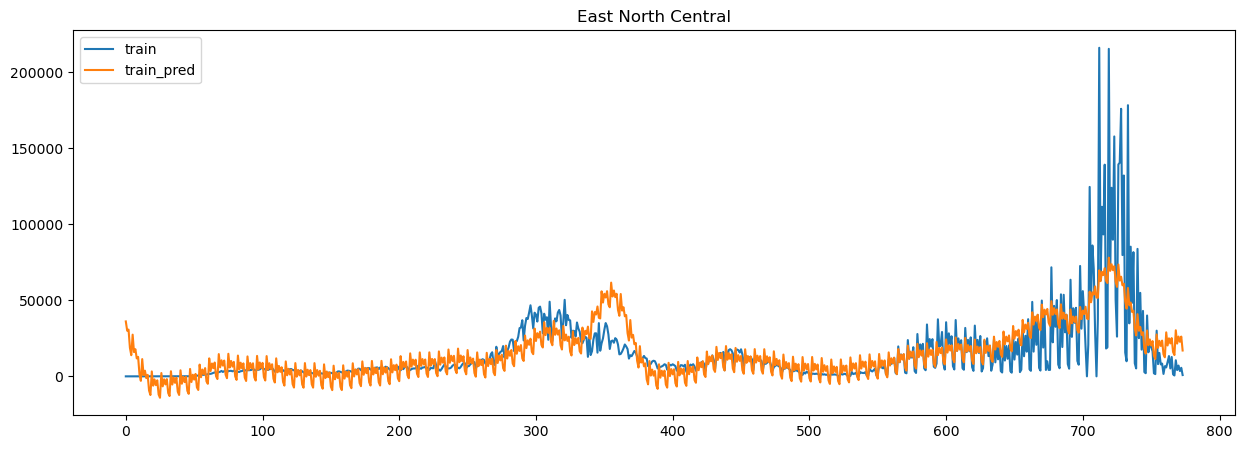

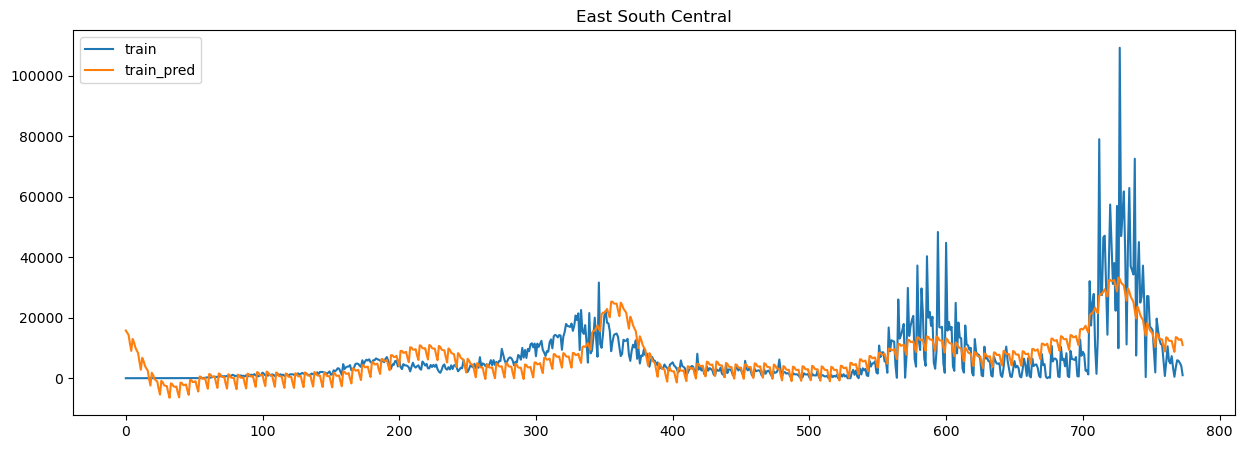

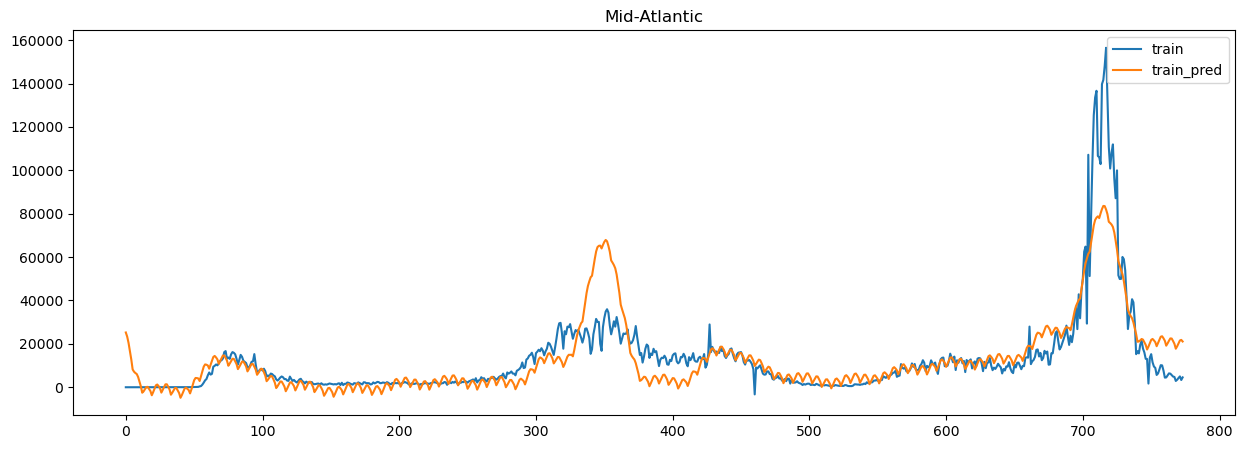

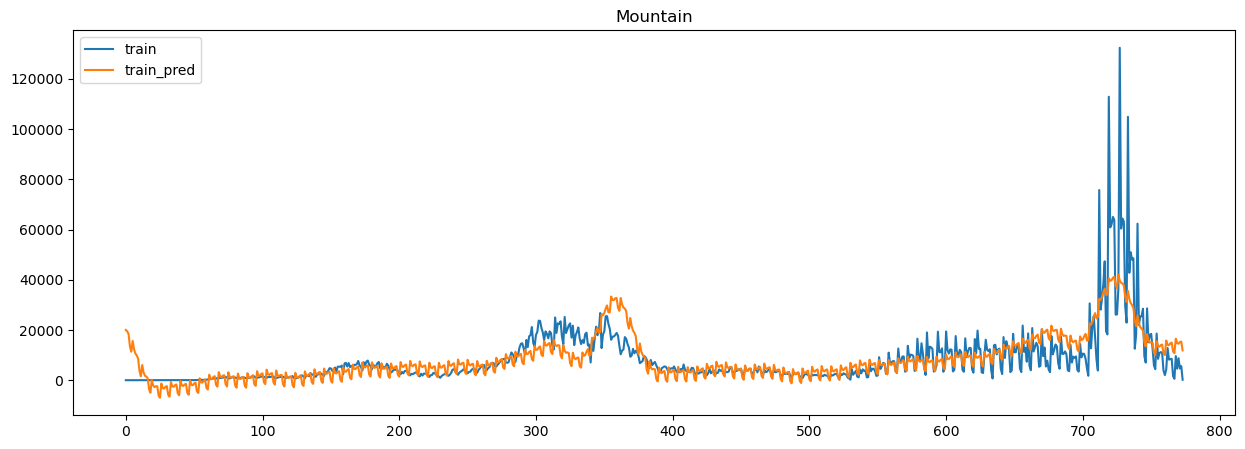

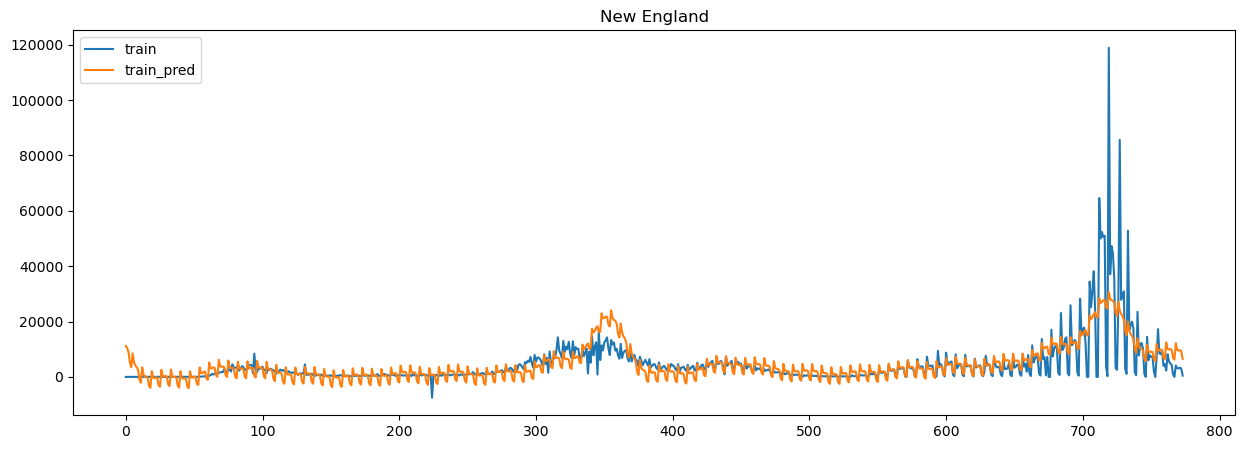

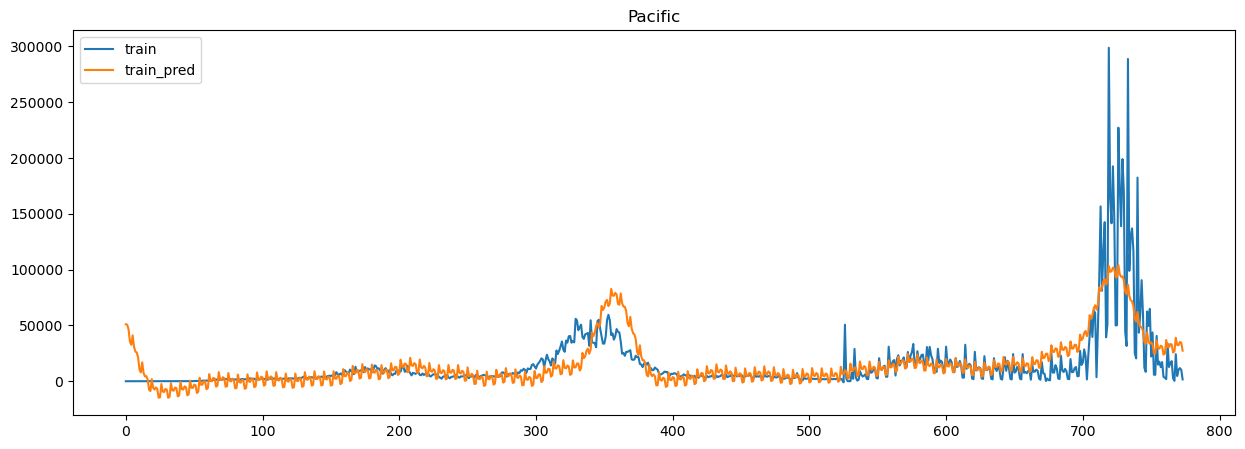

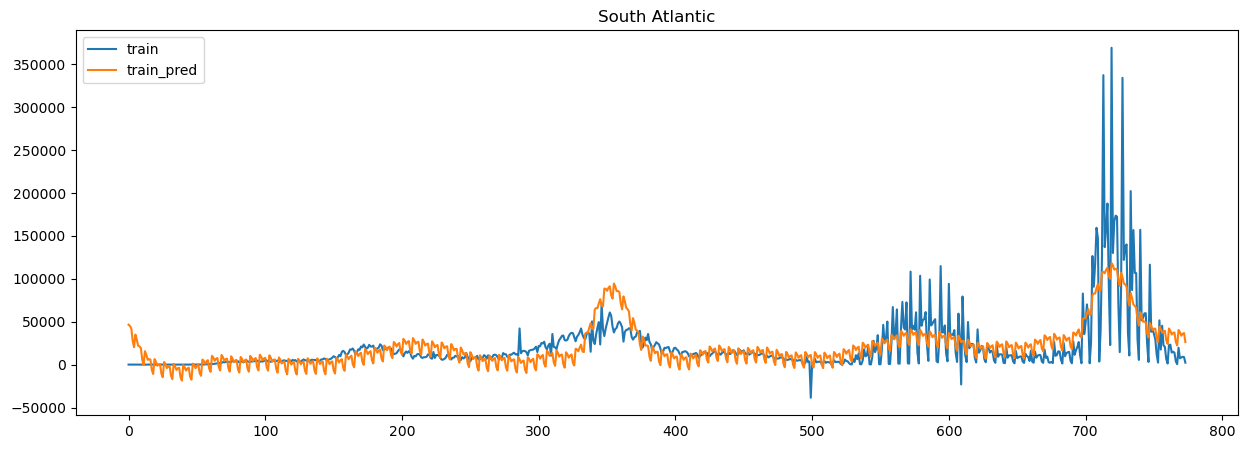

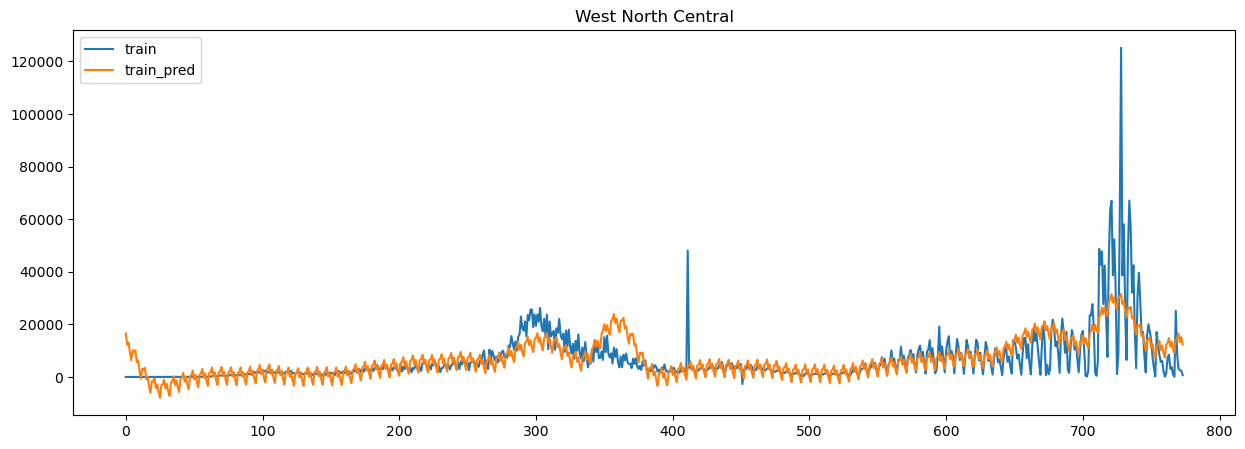

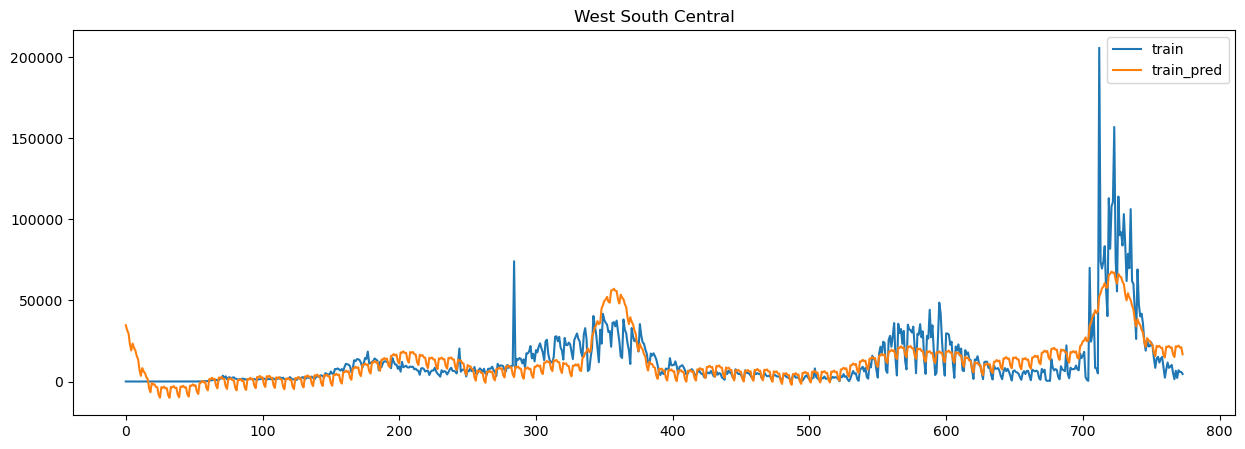

In [46]:
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    data = data1[['date', 'new_confirmed']].rename(columns = {'date': 'ds', 'new_confirmed': 'y'})
    size = round(data.shape[0]*0.2)
    train = data.iloc[:-size]
    test = data.iloc[-size:]
    model = prophet.Prophet()
    model.fit(train)
    train_pred = model.predict(train)
    pd.concat([train,train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
    plt.legend(['train', 'train_pred'])
    plt.title(data1.region.unique()[0])

In [37]:
pd.concat([test,test_pred['yhat']], axis=1)

,index,ds,y,yhat
0,774,2022-03-06,828.0,15245.516594
1,775,2022-03-07,4373.0,21964.867447
2,776,2022-03-08,7669.0,21738.947678
3,777,2022-03-09,6091.0,22554.083825
4,778,2022-03-10,6682.0,21557.443406
...,...,...,...,...
189,963,2022-09-11,0.0,34288.634169
190,964,2022-09-12,20617.0,41011.717576
191,965,2022-09-13,4988.0,40752.259146
192,966,2022-09-14,11344.0,41486.670598


15:40:25 - cmdstanpy - INFO - Chain [1] start processing
15:40:25 - cmdstanpy - INFO - Chain [1] done processing
15:40:25 - cmdstanpy - INFO - Chain [1] start processing
15:40:25 - cmdstanpy - INFO - Chain [1] done processing
15:40:26 - cmdstanpy - INFO - Chain [1] start processing
15:40:26 - cmdstanpy - INFO - Chain [1] done processing
15:40:26 - cmdstanpy - INFO - Chain [1] start processing
15:40:26 - cmdstanpy - INFO - Chain [1] done processing
15:40:26 - cmdstanpy - INFO - Chain [1] start processing
15:40:26 - cmdstanpy - INFO - Chain [1] done processing
15:40:26 - cmdstanpy - INFO - Chain [1] start processing
15:40:26 - cmdstanpy - INFO - Chain [1] done processing
15:40:26 - cmdstanpy - INFO - Chain [1] start processing
15:40:26 - cmdstanpy - INFO - Chain [1] done processing
15:40:26 - cmdstanpy - INFO - Chain [1] start processing
15:40:26 - cmdstanpy - INFO - Chain [1] done processing
15:40:26 - cmdstanpy - INFO - Chain [1] start processing
15:40:27 - cmdstanpy - INFO - Chain [1]

<Figure size 640x480 with 0 Axes>

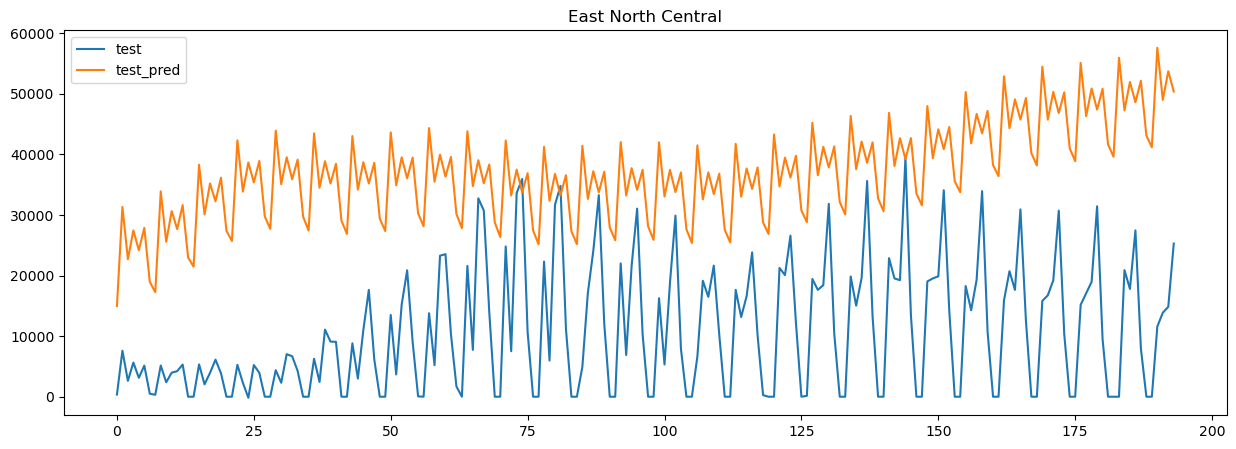

<Figure size 640x480 with 0 Axes>

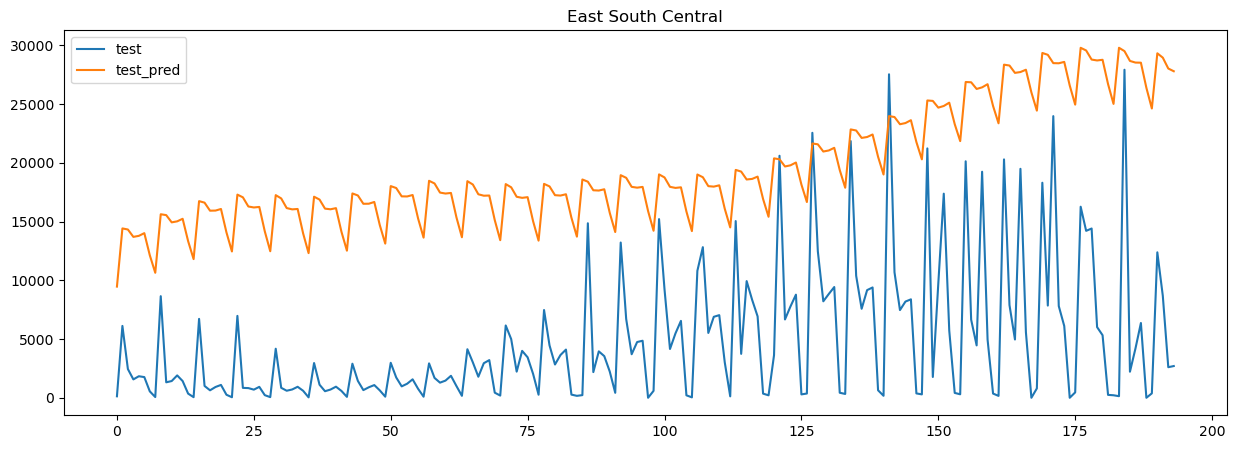

<Figure size 640x480 with 0 Axes>

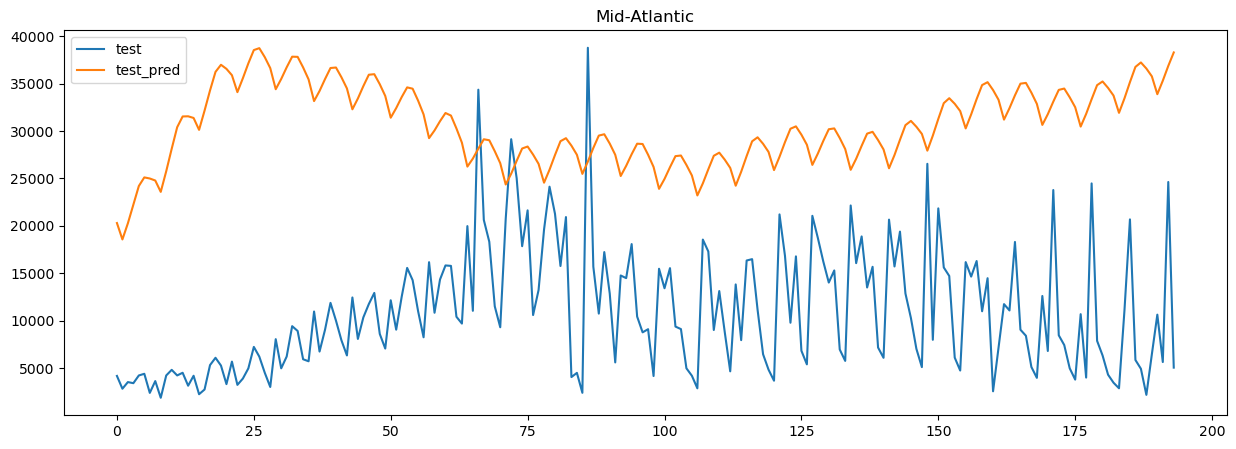

<Figure size 640x480 with 0 Axes>

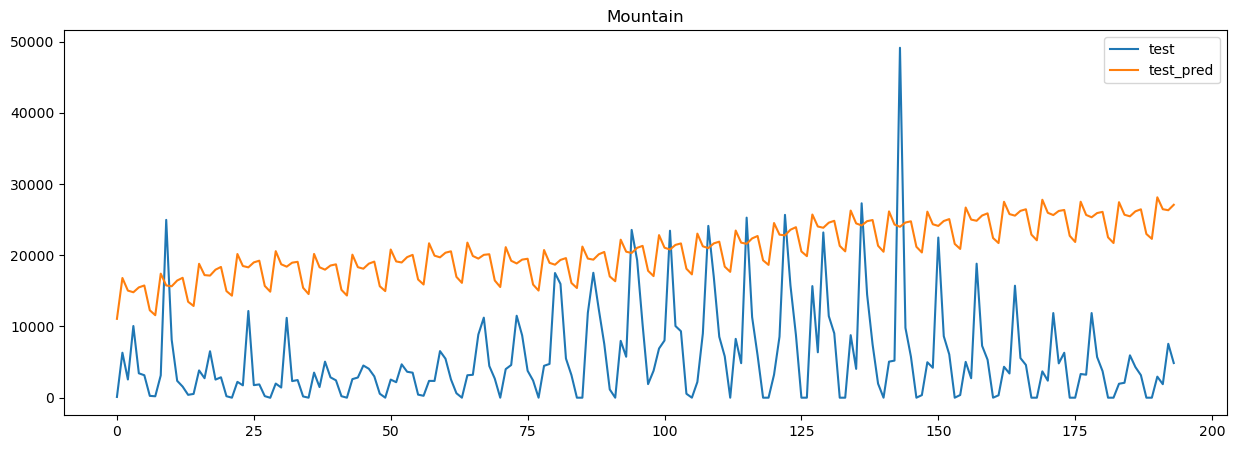

<Figure size 640x480 with 0 Axes>

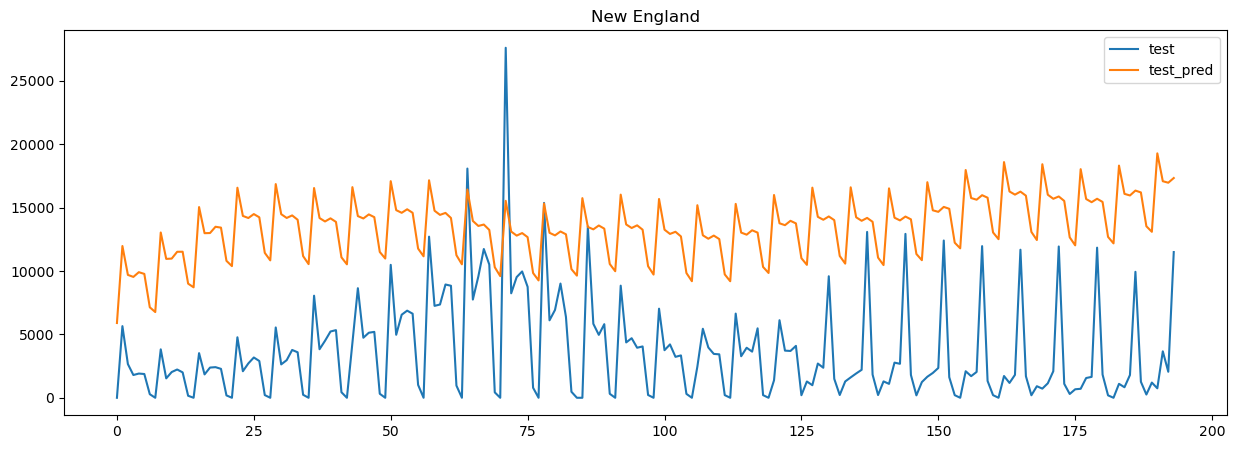

<Figure size 640x480 with 0 Axes>

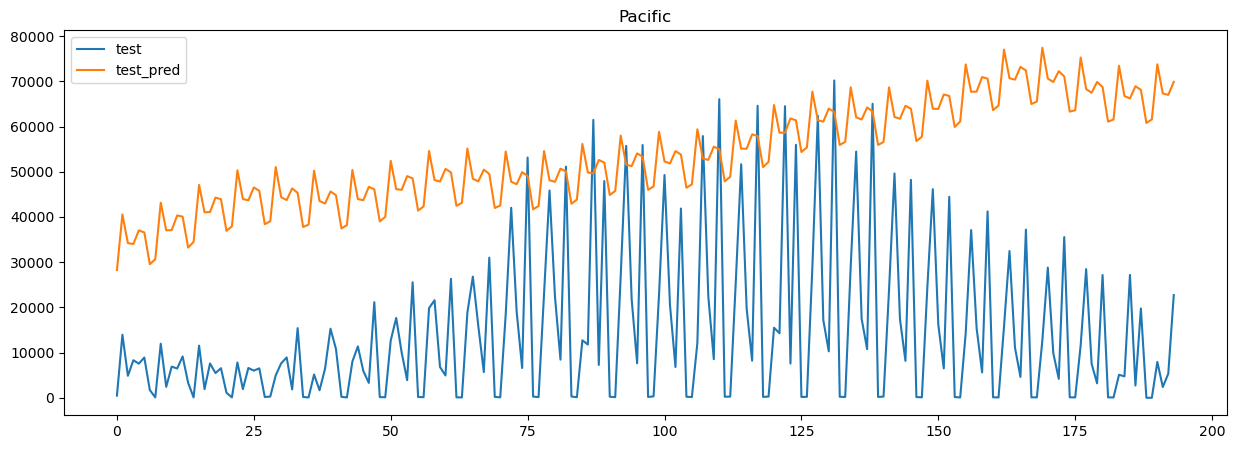

<Figure size 640x480 with 0 Axes>

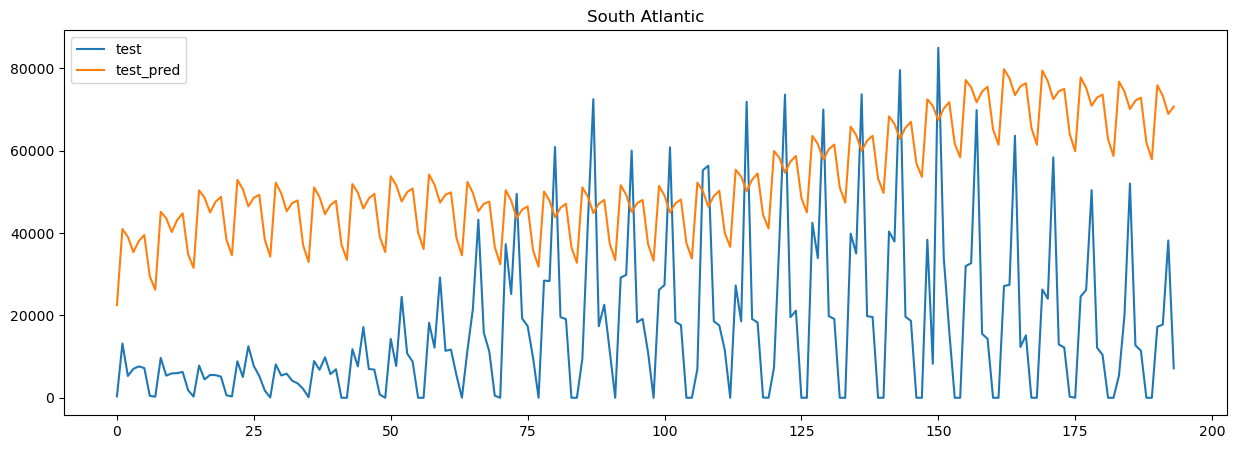

<Figure size 640x480 with 0 Axes>

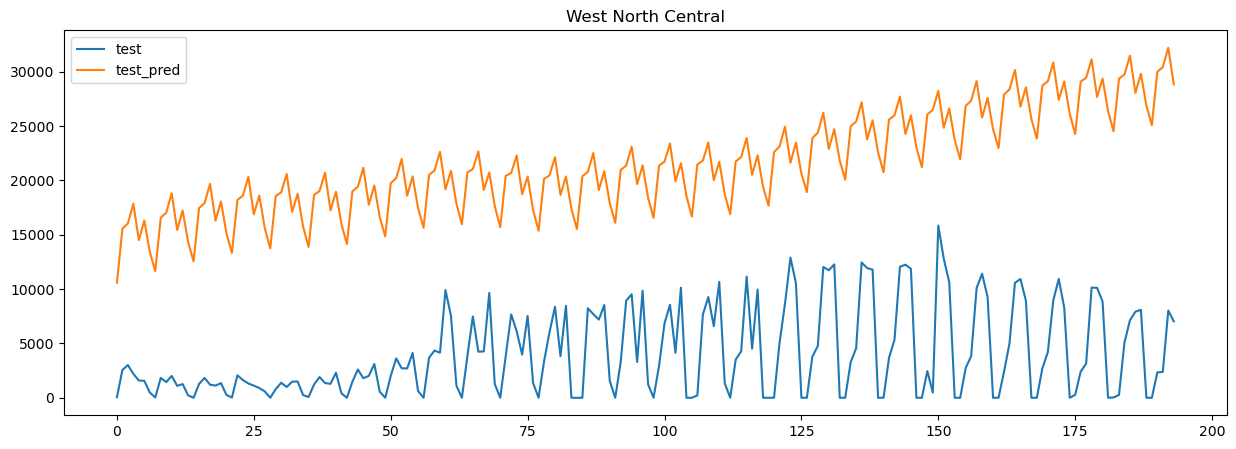

<Figure size 640x480 with 0 Axes>

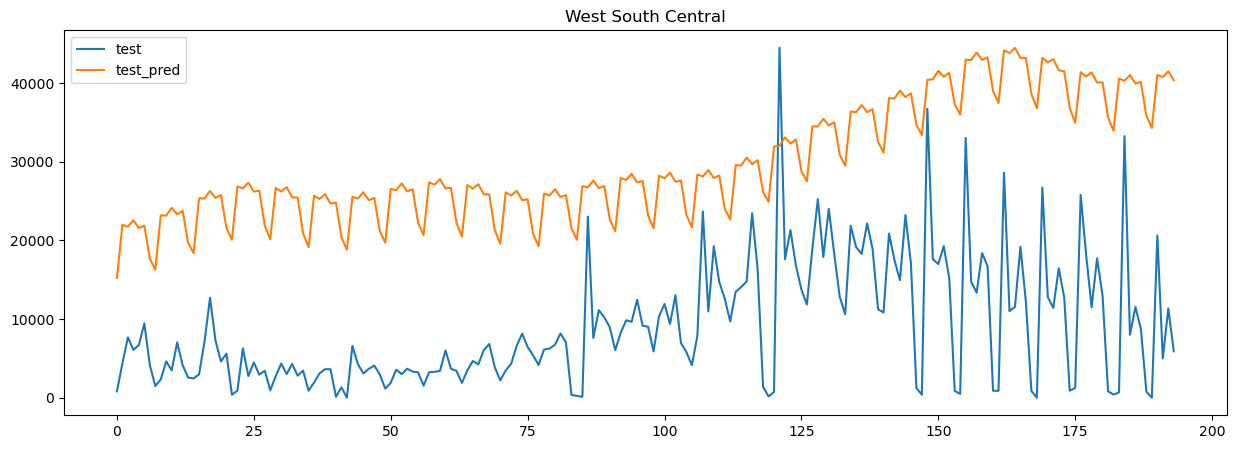

In [47]:
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    data = data1[['date', 'new_confirmed']].rename(columns = {'date': 'ds', 'new_confirmed': 'y'})
    size = round(data.shape[0]*0.2)
    train = data.iloc[:-size]
    test = data.iloc[-size:].reset_index().drop(columns = 'index')
    model = prophet.Prophet().fit(train)
    test_pred = model.predict(test)
    plt.figure()
    pd.concat([test,test_pred['yhat']], axis=1).plot(figsize=(15,5)) 
    plt.legend(['test', 'test_pred'])
    plt.title(data1.region.unique()[0])

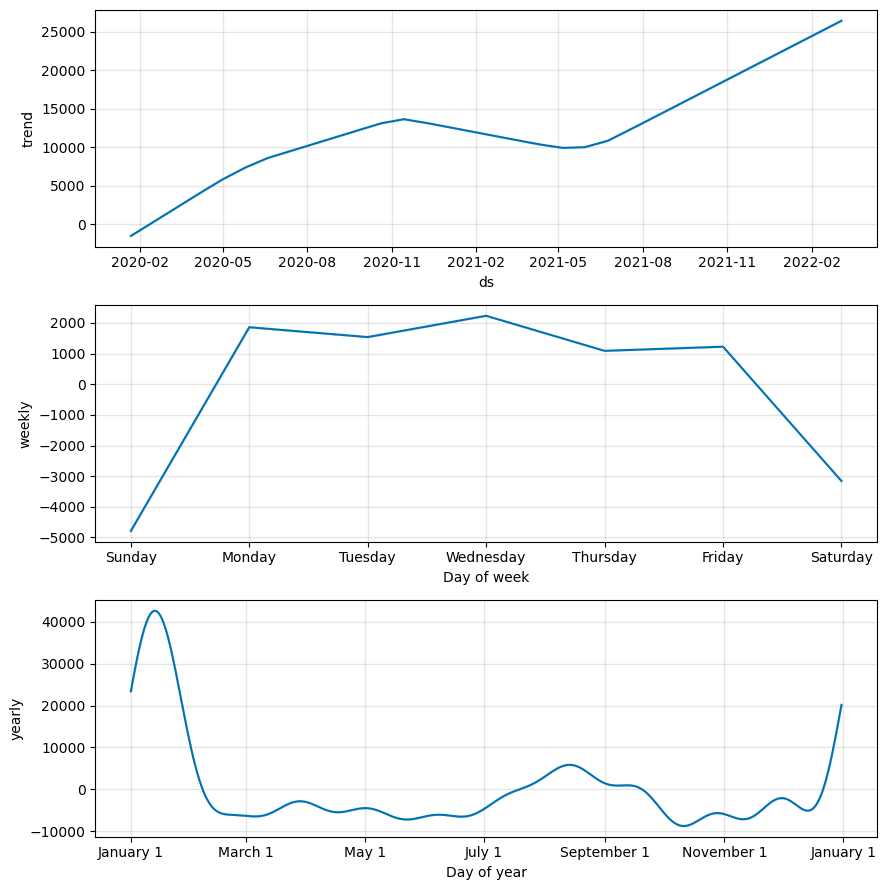

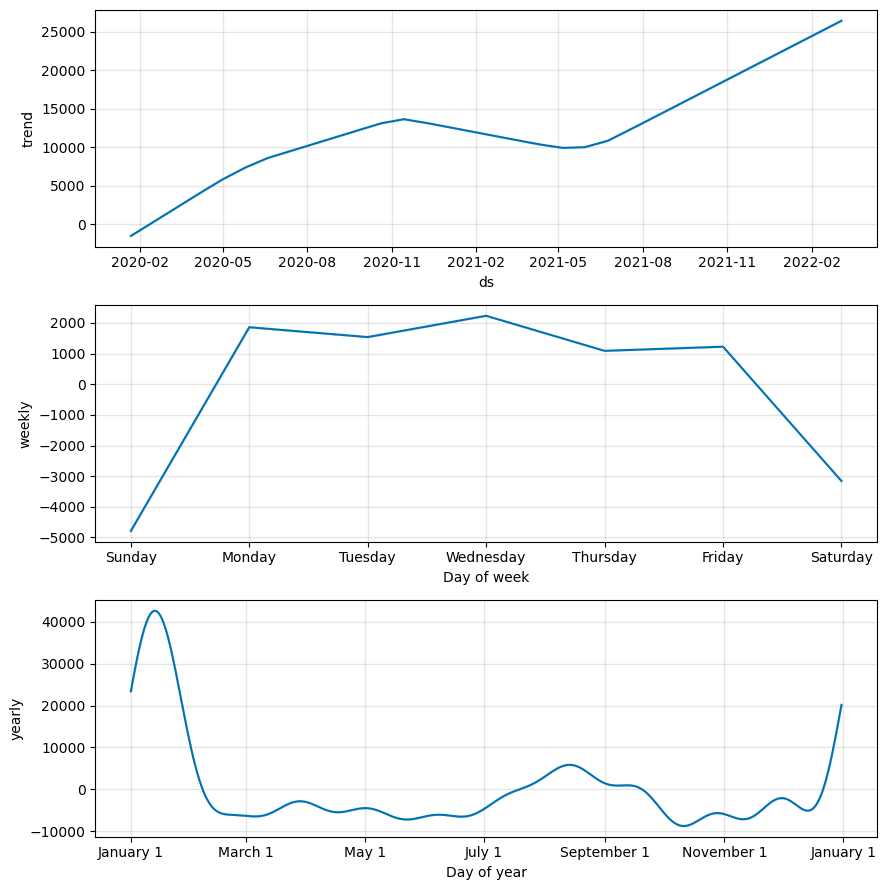

In [50]:
model.plot_components(train_pred)

In [98]:
import random
params_grid = {'changepoint_prior_scale':[0.001,0.005,0.01,0.025, 0.05, 0.1],
              'seasonality_prior_scale':[0.1,0.25,0.5,1,2,5]}
grid = ParameterGrid(params_grid)
best_params = []
best_params2 = []
best_smape = []
best_mase = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    data = data1[['date', 'new_confirmed']].rename(columns = {'date': 'ds', 'new_confirmed': 'y'})
    size = round(data.shape[0]*0.2)
    train = data.iloc[:-size]
    test = data.iloc[-size:].reset_index().drop(columns = 'index')
    params = []
    smapes = []
    mases = []
    for p in grid:
        params.append(p)
        random.seed(0)
        train_model = prophet.Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                                    seasonality_prior_scale=p['seasonality_prior_scale'])
        train_model.fit(train)
        test_pred = train_model.predict(test)
        smapetemp = smape(test.y, test_pred.yhat)
        smapes.append(smapetemp)
        masetemp = mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y)
        mases.append(masetemp)
    best_smape.append(min(smapes))
    best_params.append(params[np.argmin(smapes)])
    best_mase.append(min(mases))
    best_params2.append(params[np.argmin(mases)])
    

11:21:13 - cmdstanpy - INFO - Chain [1] start processing
11:21:13 - cmdstanpy - INFO - Chain [1] done processing
11:21:13 - cmdstanpy - INFO - Chain [1] start processing
11:21:13 - cmdstanpy - INFO - Chain [1] done processing
11:21:13 - cmdstanpy - INFO - Chain [1] start processing
11:21:13 - cmdstanpy - INFO - Chain [1] done processing
11:21:13 - cmdstanpy - INFO - Chain [1] start processing
11:21:13 - cmdstanpy - INFO - Chain [1] done processing
11:21:13 - cmdstanpy - INFO - Chain [1] start processing
11:21:13 - cmdstanpy - INFO - Chain [1] done processing
11:21:13 - cmdstanpy - INFO - Chain [1] start processing
11:21:13 - cmdstanpy - INFO - Chain [1] done processing
11:21:13 - cmdstanpy - INFO - Chain [1] start processing
11:21:13 - cmdstanpy - INFO - Chain [1] done processing
11:21:14 - cmdstanpy - INFO - Chain [1] start processing
11:21:14 - cmdstanpy - INFO - Chain [1] done processing
11:21:14 - cmdstanpy - INFO - Chain [1] start processing
11:21:14 - cmdstanpy - INFO - Chain [1]

In [100]:
best_smape

[101.4973218362544,
 104.52561217829646,
 67.05492347175459,
 102.45269704997781,
 90.59234590165771,
 102.08336156888596,
 100.66129649073332,
 103.54851337537485,
 78.75784345446088]

In [95]:
mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y)

3.1489344035215043

In [96]:
train.y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
        ...  
769    2177.0
770    6958.0
771    5901.0
772    5909.0
773    4622.0
Name: y, Length: 774, dtype: float64

In [55]:
pd.concat([test,test_pred['yhat']], axis=1)

,ds,y,yhat
0,2022-03-06,828.0,15245.516594
1,2022-03-07,4373.0,21964.867447
2,2022-03-08,7669.0,21738.947678
3,2022-03-09,6091.0,22554.083825
4,2022-03-10,6682.0,21557.443406
...,...,...,...
189,2022-09-11,0.0,34288.634169
190,2022-09-12,20617.0,41011.717576
191,2022-09-13,4988.0,40752.259146
192,2022-09-14,11344.0,41486.670598
